In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

# import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
# pl.utilities.seed.seed_everything(seed=42)
import numpy as np
import pandas as pd

import sys, os
source_path = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'preprocessing')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'metrics')
sys.path.append(source_path)
import matplotlib.pyplot as plt

from dl import NeuralNetwork, Trainer
from preprocess import (
    show_df, 
    date_features, 
    preprocess, 
    ToTorch, 
    get_loader, 
    ts_split,
    cont_cat_split,
    dataloader_by_stock,
    get_train_data
)
from metrics import calc_spread_return_sharpe
print(torch.__version__)

1.11.0


In [2]:
print(torch.version.cuda), torch.cuda.is_available(), torch.cuda.device_count()

11.3


(None, True, 1)

computer_name1 = 'gilbe'
computer_name2 = 'Gilberto-BE'

ROOT_PATH = f'c:/Users/{computer_name1}/Documents/TokyoData'


'/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/financials.csv'
'/train_files/trades.csv'

train_df = pd.read_csv(f'{ROOT_PATH}/train_files/stock_prices.csv')
train_df['Date'] = pd.to_datetime(train_df['Date']) 
train_df.set_index('Date', inplace=True)
# train_df = date_features(train_df)
print(train_df.head(2))

train_options = pd.read_csv(f'{ROOT_PATH}/train_files/options.csv', low_memory=False)
train_financials = pd.read_csv(f'{ROOT_PATH}/train_files/financials.csv', low_memory=False)
train_trades = pd.read_csv(f'{ROOT_PATH}/train_files/trades.csv', low_memory=False)

In [3]:
# n_stocks = train_df.SecuritiesCode.nunique()
# n_stocks = train_df.SecuritiesCode.unique()
# for n in n_stocks:
#     print(train_df[train_df['SecuritiesCode'] == n].shape)

##  Get Data and train a Neural Network

# Get the unique security codes

In [4]:
train_df = get_train_data()
print('Unique adjustment factor:', train_df['AdjustmentFactor'].unique())
print(train_df['AdjustmentFactor'])
train_df.head()

Unique adjustment factor: [ 1.          0.5         5.          0.33333333  0.83333333  0.25
  0.90909091  0.1        10.          0.2         0.95238095  2.
  0.14285714  0.66666667  0.86956522  0.76923077  0.8         4.
 20.        ]
Date
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
             ... 
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
Name: AdjustmentFactor, Length: 2332531, dtype: float64


,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
Date,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
2017-01-04,20170104_1332,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2017-01-04,20170104_1333,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
2017-01-04,20170104_1376,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
2017-01-04,20170104_1377,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


# Create model

In [5]:
TS_IN_FEATURES = 1

CAT_FEATURES = 4 #cat.shape[1]

print('CAT_FEATURES:', CAT_FEATURES)
EMBEDDING_DIM = 100
NO_EMBEDDING = 2000 #2 * len(df_train_cat)
print('NO_EMBEDDING:', NO_EMBEDDING)

model = NeuralNetwork(
    in_features=TS_IN_FEATURES, 
    units=512,
    out_features=1, 
    categorical_dim=CAT_FEATURES,
    no_embedding=NO_EMBEDDING, 
    emb_dim=EMBEDDING_DIM,
    n_blocks=30
)

print(model)

CAT_FEATURES: 4
NO_EMBEDDING: 2000
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (embedding): Embedding(2000, 100)
  (embedding_to_hidden): Linear(in_features=100, out_features=512, bias=True)
  (embedding_output): Linear(in_features=512, out_features=1, bias=True)
  (cont_input): Linear(in_features=1, out_features=512, bias=True)
  (hidden_layer): Linear(in_features=516, out_features=516, bias=True)
  (output_layer): Linear(in_features=516, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [6]:
# Loop throug each stock

Start training for stock: 1301


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['RowId'] = np.squeeze(enc.fit_transform(df['RowId'].to_numpy().reshape(-1, 1)))


continuos shape: (1202, 8)  categorical shape: (1202, 4)
Using cuda-device
Epoch: <<< 0 >>>


C:\Users\gilbe\anaconda3\envs\tokyo\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:239.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train metrics: {'mse': 7.139378547668457, 'mae': 2.655113935470581}
Validation metrics: {'mse': 16.805675506591797, 'mae': 3.8814876079559326}
Average train loss: 0.20239787101745604 | Average val loss: 13.41589641571045
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 9.825859069824219, 'mae': 3.1268417835235596}
Validation metrics: {'mse': 0.7538576722145081, 'mae': 0.8117598295211792}
Average train loss: 0.9102155685424804 | Average val loss: 2.2663586139678955
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 6.92532205581665, 'mae': 2.624743938446045}
Validation metrics: {'mse': 1.5166255235671997, 'mae': 1.2302746772766113}
Average train loss: 0.161105740070343 | Average val loss: 1.9395979642868042
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.7061000466346741, 'mae': 0.822910487651825}
Validation metrics: {'mse': 1.3128561973571777,

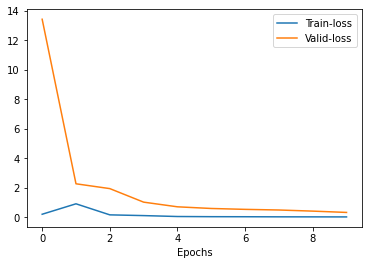

####################

Start training for stock: 1332
continuos shape: (1202, 8)  categorical shape: (1202, 4)
Using cuda-device
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['RowId'] = np.squeeze(enc.fit_transform(df['RowId'].to_numpy().reshape(-1, 1)))


Train metrics: {'mse': 0.12964585423469543, 'mae': 0.2802630662918091}
Validation metrics: {'mse': 0.14454808831214905, 'mae': 0.35351550579071045}
Average train loss: 0.008161869645118714 | Average val loss: 0.5588547587394714
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.1795523464679718, 'mae': 0.35341256856918335}
Validation metrics: {'mse': 0.11087696999311447, 'mae': 0.31478336453437805}
Average train loss: 0.027457037568092348 | Average val loss: 0.17524783313274384
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.28121113777160645, 'mae': 0.44339802861213684}
Validation metrics: {'mse': 0.5412822961807251, 'mae': 0.6771803498268127}
Average train loss: 0.006481979042291641 | Average val loss: 0.680205225944519
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 6.066817283630371, 'mae': 2.432494878768921}
Validation metrics: {'mse':

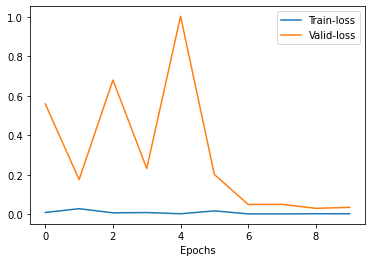

####################

Start training for stock: 1333
continuos shape: (1202, 8)  categorical shape: (1202, 4)
Using cuda-device
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['RowId'] = np.squeeze(enc.fit_transform(df['RowId'].to_numpy().reshape(-1, 1)))


Train metrics: {'mse': 0.9967868328094482, 'mae': 0.9710351824760437}
Validation metrics: {'mse': 0.12796491384506226, 'mae': 0.30226966738700867}
Average train loss: 0.0013957480899989606 | Average val loss: 0.24769067764282227
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.05130486935377121, 'mae': 0.15926116704940796}
Validation metrics: {'mse': 0.3317408263683319, 'mae': 0.5575100183486938}
Average train loss: 0.007495824992656708 | Average val loss: 0.23572540283203125
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.24597404897212982, 'mae': 0.46240103244781494}
Validation metrics: {'mse': 0.0052501908503472805, 'mae': 0.06607133895158768}
Average train loss: 0.11892521381378174 | Average val loss: 0.007335119880735874
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.05946442484855652, 'mae': 0.20900481939315796}
Validation metric

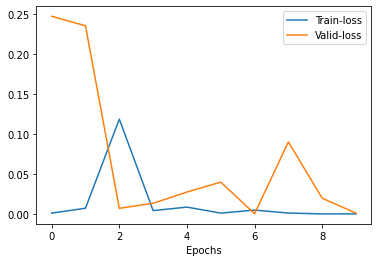

####################

Start training for stock: 1376
continuos shape: (1202, 8)  categorical shape: (1202, 4)
Using cuda-device
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['RowId'] = np.squeeze(enc.fit_transform(df['RowId'].to_numpy().reshape(-1, 1)))


Train metrics: {'mse': 0.002932156901806593, 'mae': 0.04417062923312187}
Validation metrics: {'mse': 0.001573544112034142, 'mae': 0.03216055408120155}
Average train loss: 0.0006380060221999884 | Average val loss: 0.0033695949241518974
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.005269346293061972, 'mae': 0.05131881311535835}
Validation metrics: {'mse': 0.02172831818461418, 'mae': 0.10854223370552063}
Average train loss: 0.00015907424967736005 | Average val loss: 0.0651286244392395
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.20372766256332397, 'mae': 0.3858911991119385}
Validation metrics: {'mse': 0.7921953201293945, 'mae': 0.6780737042427063}
Average train loss: 0.0003928943071514368 | Average val loss: 1.8385366201400757
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.8374353647232056, 'mae': 0.8885959982872009}
Validation met

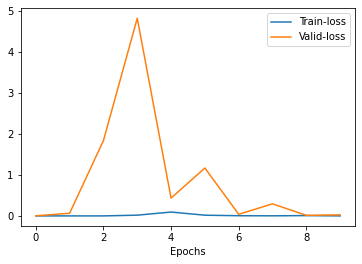

####################

Start training for stock: 1377
continuos shape: (1202, 8)  categorical shape: (1202, 4)
Using cuda-device
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['RowId'] = np.squeeze(enc.fit_transform(df['RowId'].to_numpy().reshape(-1, 1)))


Train metrics: {'mse': 0.028116710484027863, 'mae': 0.13955096900463104}
Validation metrics: {'mse': 0.09683000296354294, 'mae': 0.2512986361980438}
Average train loss: 0.0004059683531522751 | Average val loss: 0.8901599645614624
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.123304583132267, 'mae': 0.3097931742668152}
Validation metrics: {'mse': 0.6995263695716858, 'mae': 0.5971204042434692}
Average train loss: 0.0018974119797348977 | Average val loss: 7.489897727966309
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.06760425865650177, 'mae': 0.2387680858373642}
Validation metrics: {'mse': 0.08762668073177338, 'mae': 0.28277719020843506}
Average train loss: 0.01116928905248642 | Average val loss: 0.06688196957111359
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.10108476877212524, 'mae': 0.27766624093055725}
Validation metrics: {'ms

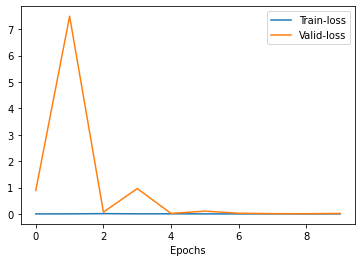

####################

Start training for stock: 1379
continuos shape: (1202, 8)  categorical shape: (1202, 4)
Using cuda-device
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['RowId'] = np.squeeze(enc.fit_transform(df['RowId'].to_numpy().reshape(-1, 1)))


Train metrics: {'mse': 3.0054986476898193, 'mae': 1.4874907732009888}
Validation metrics: {'mse': 0.04118352755904198, 'mae': 0.1921350508928299}
Average train loss: 0.0054131288081407545 | Average val loss: 0.24356649816036224
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 5.5467329025268555, 'mae': 2.1416015625}
Validation metrics: {'mse': 0.11643294245004654, 'mae': 0.2956598699092865}
Average train loss: 0.01396479457616806 | Average val loss: 2.474388599395752
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 2.504528760910034, 'mae': 1.3937575817108154}
Validation metrics: {'mse': 0.1481698900461197, 'mae': 0.3563079833984375}
Average train loss: 0.16087162494659424 | Average val loss: 2.4174649715423584
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.08383701741695404, 'mae': 0.22123487293720245}
Validation metrics: {'mse': 0.0328085

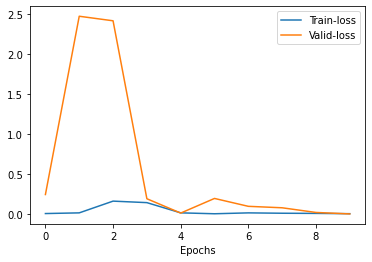

####################

Start training for stock: 1381
CPU times: total: 9min 41s
Wall time: 9min 42s


In [7]:
%%time
stocks = train_df['SecuritiesCode'].unique()
count = 0
for s in stocks:
    print(f'Start training for stock: {s}')
    train_loader, val_dataloader = None, None
    if count > 5:
        break
    train_dataloader, val_dataloader = dataloader_by_stock(train_df, s)

    torch.autograd.set_detect_anomaly(True)
    trainer = Trainer(model, lr=1.3e-6)
    trainer.fit_epochs(
        train_dataloader, 
        val_dataloader, 
        use_cyclic_lr=True, 
        x_cat=True, 
        epochs=10
    )
    print('#' * 20)
    print()
    count += 1
    
    